<a href="https://www.kaggle.com/code/aslifidan/lms-model-comparison-explainability?scriptVersionId=249662217" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# LMS Model Comparison & Explainability

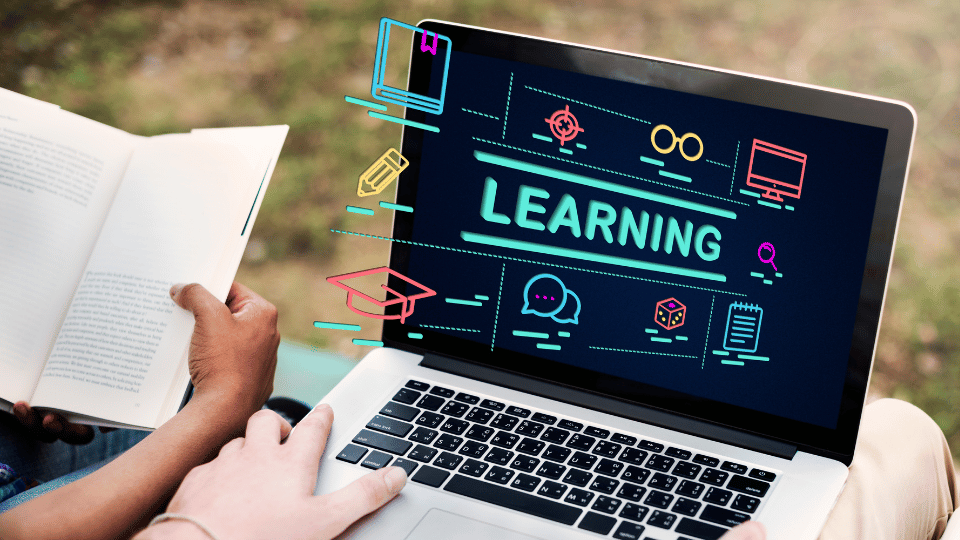

This project presents a comprehensive learning analytics workflow tailored for Learning and Development (L&D) teams. Using realistic Learning management system-style datasets, we analyze employee training participation, satisfaction, performance, and skill development. Through advanced modeling techniques such as regression and classification, we predict training outcomes and identify key drivers of success using SHAP explainability. The project also includes model benchmarking, skill gap analysis, and actionable insights to support data-driven decision-making in corporate learning environments.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import shap
import matplotlib.pyplot as plt

In [2]:
employees = pd.read_csv('/kaggle/input/lms-analysis/employees.csv')
trainings = pd.read_csv('/kaggle/input/lms-analysis/trainings.csv')
training_logs = pd.read_csv('/kaggle/input/lms-analysis/training_logs.csv')
mentorship = pd.read_csv('/kaggle/input/lms-analysis/mentorship.csv')
survey_results = pd.read_csv('/kaggle/input/lms-analysis/survey_results.csv')
skill_scores = pd.read_csv('/kaggle/input/lms-analysis/skill_scores.csv')

# 1. Data Preview & Integrity Check

In this section, we load and preview all relevant datasets including employees, trainings, training records, mentorship data, survey results, and skill scores.  
We also perform initial sanity checks such as dataset dimensions and missing value counts to ensure the data is clean and ready for analysis.

In [3]:
print("Employees:")
display(employees.head())

print("Trainings:")
display(trainings.head())

print("Training Records:")
display(training_logs.head())

print("Mentorship Data:")
display(mentorship.head())

print("Survey Results:")
display(survey_results.head())

print("Skill Scores:")
display(skill_scores.head())

Employees:


,employee_id,name,position,education_level,hire_date,age
0,1,William Robertson,Training Coordinator,Master,2024-02-19,52
1,2,Rachel Carey,Data Analyst,High School,2024-02-05,37
2,3,Ronnie Smith,Training Coordinator,Bachelor,2024-10-24,48
3,4,Michael Acevedo,Software Developer,Bachelor,2024-10-07,40
4,5,Jennifer Brown,Sales Executive,Bachelor,2025-06-22,40


Trainings:


,training_id,title,training_type,duration_hours,roi_target_usd,creation_date
0,1,Compliance Training 1,Leadership,1,1000,2024-08-28
1,2,Soft Skills Training 2,Technical Skills,12,1000,2025-01-11
2,3,Compliance Training 3,Onboarding,11,300,2024-01-10
3,4,Soft Skills Training 4,Onboarding,8,700,2023-09-15
4,5,Technical Skills Training 5,Leadership,4,1500,2024-04-12


Training Records:


,log_id,employee_id,training_id,completion_status,score,completion_date
0,1,6,12,Completed,61,2024-08-05
1,2,32,16,Completed,71,2025-01-29
2,3,82,4,Completed,84,2024-11-15
3,4,22,14,Completed,96,2025-02-25
4,5,100,13,Completed,64,2024-12-29


Mentorship Data:


,employee_id,mentor_id,mentorship_start,mentorship_end,hours_spent,program_type
0,71,21,2024-09-15,2025-06-29,5,Leadership Mentoring
1,11,78,2024-12-28,2025-06-29,19,Skill-based Mentoring
2,57,45,2024-09-25,2025-06-29,10,Skill-based Mentoring
3,40,42,2024-10-15,2025-06-29,21,Leadership Mentoring
4,48,53,2025-01-21,2025-06-29,8,Leadership Mentoring


Survey Results:


,employee_id,training_id,satisfaction_score,feedback_text,survey_date
0,73,9,4,Woman respond total describe small notice stuf...,2024-11-14
1,96,4,4,Authority current rest miss than.,2024-10-14
2,9,4,4,Any two suggest manage than hand season cup tr...,2024-07-29
3,93,17,4,Space conference area everybody Democrat enoug...,2024-07-10
4,25,16,2,Detail buy development yard like resource inve...,2024-10-17


Skill Scores:


,employee_id,skill_name,score,evaluation_date
0,98,Technical Knowledge,9,2025-01-18
1,90,Problem Solving,3,2024-12-17
2,43,Problem Solving,9,2024-07-25
3,58,Problem Solving,7,2024-08-13
4,7,Leadership,4,2025-06-13


In [4]:
print("\nDataset Dimensions:")
print(f"Employees: {employees.shape}")
print(f"Trainings: {trainings.shape}")
print(f"Training Records: {training_logs.shape}")
print(f"Mentorship: {mentorship.shape}")
print(f"Survey Results: {survey_results.shape}")
print(f"Skill Scores: {skill_scores.shape}")


Dataset Dimensions:
Employees: (100, 6)
Trainings: (20, 6)
Training Records: (500, 6)
Mentorship: (60, 6)
Survey Results: (400, 5)
Skill Scores: (400, 4)


In [5]:
print("\nMissing Value Check:")
for name, df in zip(
    ["Employees", "Trainings", "Training Records", "Mentorship", "Survey Results", "Skill Scores"],
    [employees, trainings, training_logs, mentorship, survey_results, skill_scores]
):
    print(f"{name}: {df.isnull().sum().sum()} missing values")


Missing Value Check:
Employees: 0 missing values
Trainings: 0 missing values
Training Records: 0 missing values
Mentorship: 0 missing values
Survey Results: 0 missing values
Skill Scores: 0 missing values


# 2. Training Participation & Engagement Analysis

This section analyzes training completion rates, score distributions, popular training topics, time-based participation trends, and the impact of training durations on completion. Participation behavior is evaluated from both a temporal and user-based perspective, supported by clear visualizations.

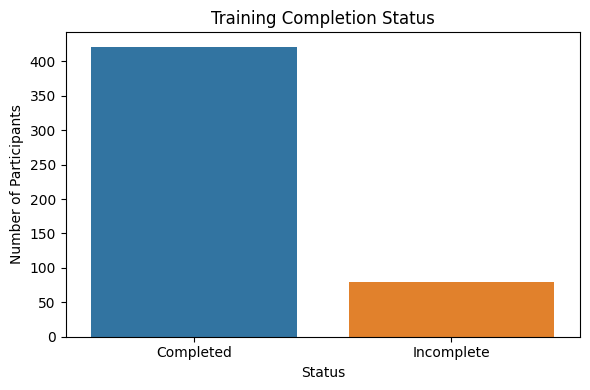

In [6]:
completion_counts = training_logs['completion_status'].value_counts()

plt.figure(figsize=(6, 4))
sns.barplot(x=completion_counts.index, y=completion_counts.values)
plt.title("Training Completion Status")
plt.ylabel("Number of Participants")
plt.xlabel("Status")
plt.tight_layout()
plt.show()

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


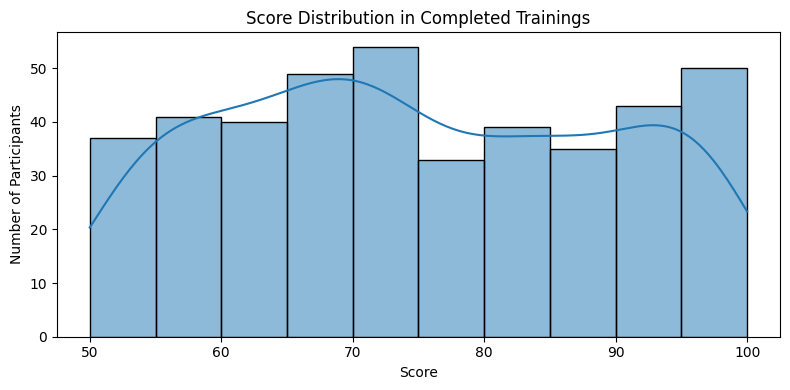

In [7]:
completed_logs = training_logs[training_logs['completion_status'] == 'Completed']

plt.figure(figsize=(8, 4))
sns.histplot(completed_logs['score'], bins=10, kde=True)
plt.title("Score Distribution in Completed Trainings")
plt.xlabel("Score")
plt.ylabel("Number of Participants")
plt.tight_layout()
plt.show()

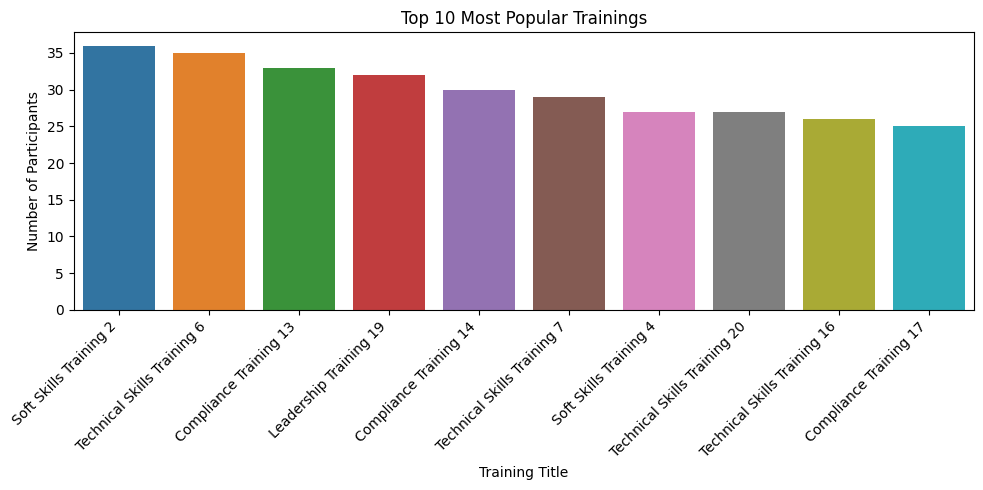

In [8]:
popular_trainings = training_logs['training_id'].value_counts().head(10)
popular_training_titles = trainings.set_index('training_id').loc[popular_trainings.index]['title']

plt.figure(figsize=(10, 5))
sns.barplot(x=popular_training_titles, y=popular_trainings.values)
plt.xticks(rotation=45, ha='right')
plt.title("Top 10 Most Popular Trainings")
plt.ylabel("Number of Participants")
plt.xlabel("Training Title")
plt.tight_layout()
plt.show()

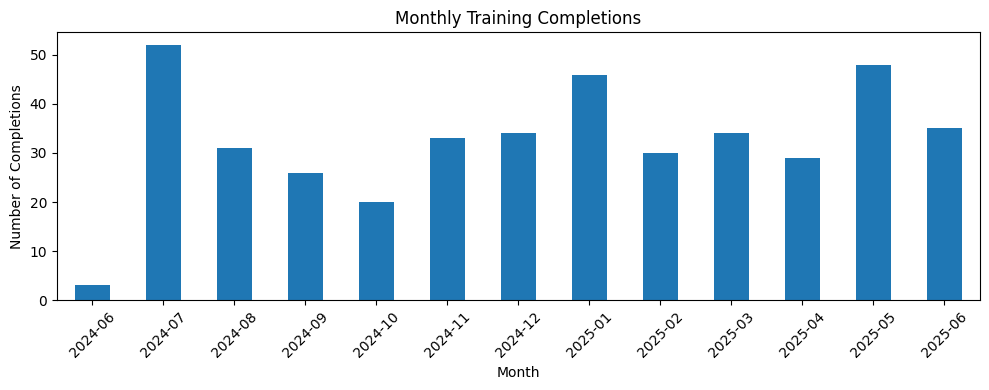

In [9]:
training_logs['completion_date'] = pd.to_datetime(training_logs['completion_date'], errors='coerce')

monthly_participation = training_logs[training_logs['completion_status'] == 'Completed']
monthly_participation = monthly_participation.groupby(training_logs['completion_date'].dt.to_period("M")).size()

plt.figure(figsize=(10, 4))
monthly_participation.plot(kind='bar')
plt.title("Monthly Training Completions")
plt.ylabel("Number of Completions")
plt.xlabel("Month")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

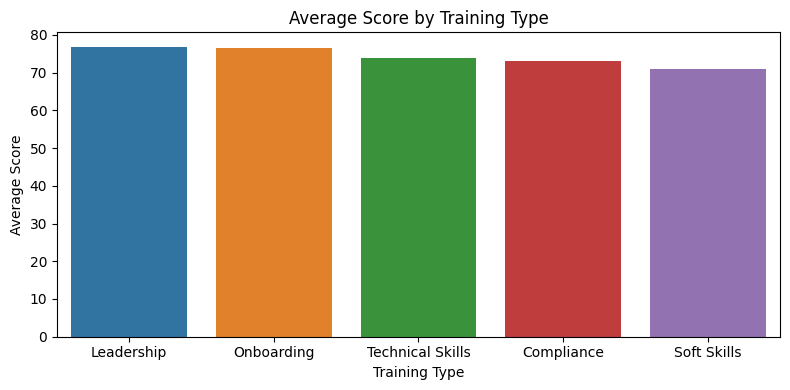

In [10]:
merged_df = pd.merge(completed_logs, trainings, on='training_id')
avg_score_by_type = merged_df.groupby('training_type')['score'].mean().sort_values(ascending=False)

plt.figure(figsize=(8, 4))
sns.barplot(x=avg_score_by_type.index, y=avg_score_by_type.values)
plt.title("Average Score by Training Type")
plt.ylabel("Average Score")
plt.xlabel("Training Type")
plt.tight_layout()
plt.show()

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


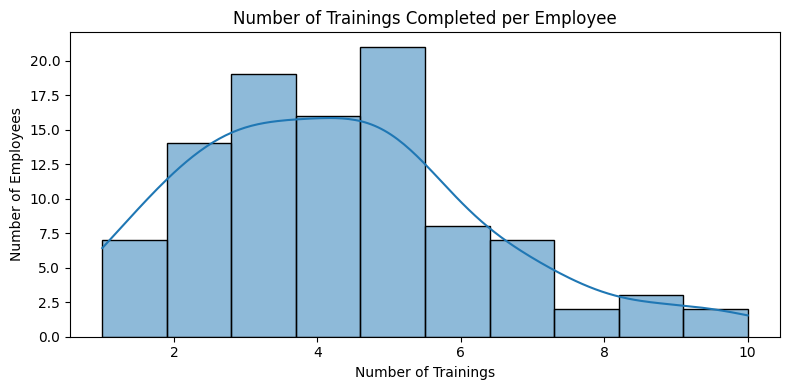

In [11]:
participation_counts = training_logs[training_logs['completion_status'] == 'Completed']['employee_id'].value_counts()

plt.figure(figsize=(8, 4))
sns.histplot(participation_counts, bins=10, kde=True)
plt.title("Number of Trainings Completed per Employee")
plt.xlabel("Number of Trainings")
plt.ylabel("Number of Employees")
plt.tight_layout()
plt.show()

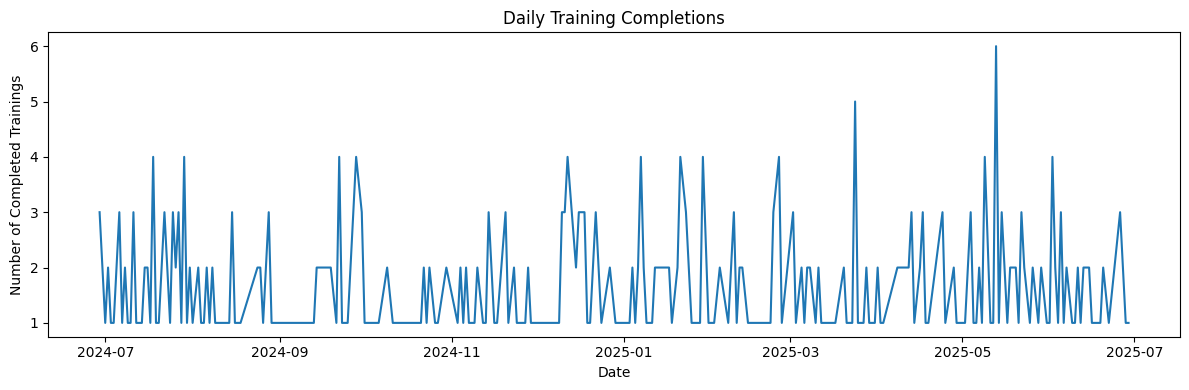

In [12]:
training_logs['completion_date'] = pd.to_datetime(training_logs['completion_date'], errors='coerce')

daily_counts = training_logs[training_logs['completion_status'] == 'Completed'].groupby(
    training_logs['completion_date'].dt.date
).size()

plt.figure(figsize=(12, 4))
daily_counts.plot()
plt.title("Daily Training Completions")
plt.xlabel("Date")
plt.ylabel("Number of Completed Trainings")
plt.tight_layout()
plt.show()

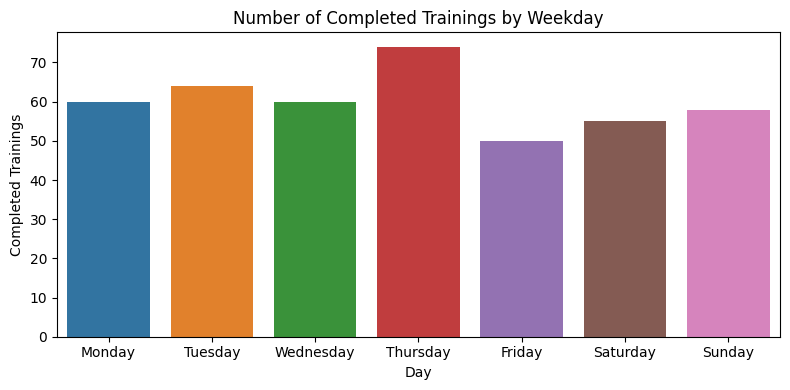

In [13]:
training_logs['weekday'] = training_logs['completion_date'].dt.day_name()
weekday_counts = training_logs[training_logs['completion_status'] == 'Completed']['weekday'].value_counts().reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
])

plt.figure(figsize=(8, 4))
sns.barplot(x=weekday_counts.index, y=weekday_counts.values)
plt.title("Number of Completed Trainings by Weekday")
plt.ylabel("Completed Trainings")
plt.xlabel("Day")
plt.tight_layout()
plt.show()

<Figure size 1000x500 with 0 Axes>

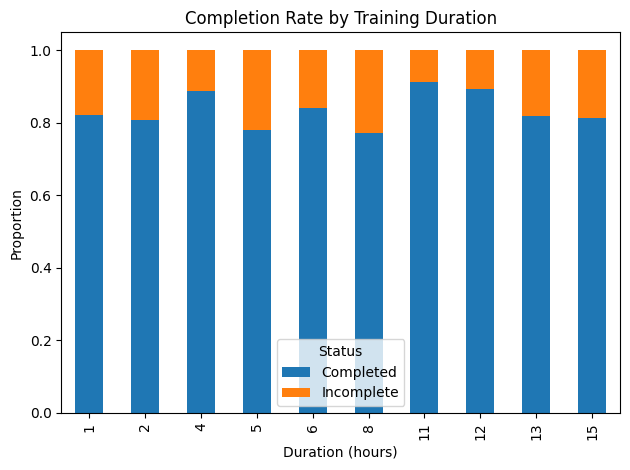

In [14]:
merged = pd.merge(training_logs, trainings, on='training_id')
completion_by_duration = merged.groupby('duration_hours')['completion_status'].value_counts(normalize=True).unstack().fillna(0)

plt.figure(figsize=(10, 5))
completion_by_duration.plot(kind='bar', stacked=True)
plt.title("Completion Rate by Training Duration")
plt.ylabel("Proportion")
plt.xlabel("Duration (hours)")
plt.legend(title="Status")
plt.tight_layout()
plt.show()

# 3. Skill Gap Detection

Skill scores have been analyzed by position. Radar charts and heatmaps were used to identify which positions lack specific competencies. Positions with particularly low technical knowledge levels were highlighted.

In [15]:
merged_skills = pd.merge(skill_scores, employees[['employee_id', 'position']], on='employee_id')

avg_skill_by_position = merged_skills.groupby(['position', 'skill_name'])['score'].mean().unstack()

display(avg_skill_by_position.round(1))

skill_name,Communication,Data Analysis,Leadership,Problem Solving,Technical Knowledge
position,,,,,
Data Analyst,4.6,5.1,6.1,7.4,5.9
HR Specialist,5.5,4.7,6.0,5.6,6.5
Sales Executive,6.1,5.7,5.4,6.4,5.0
Software Developer,4.5,6.9,5.8,5.4,6.7
Training Coordinator,4.6,4.7,3.9,5.6,6.6


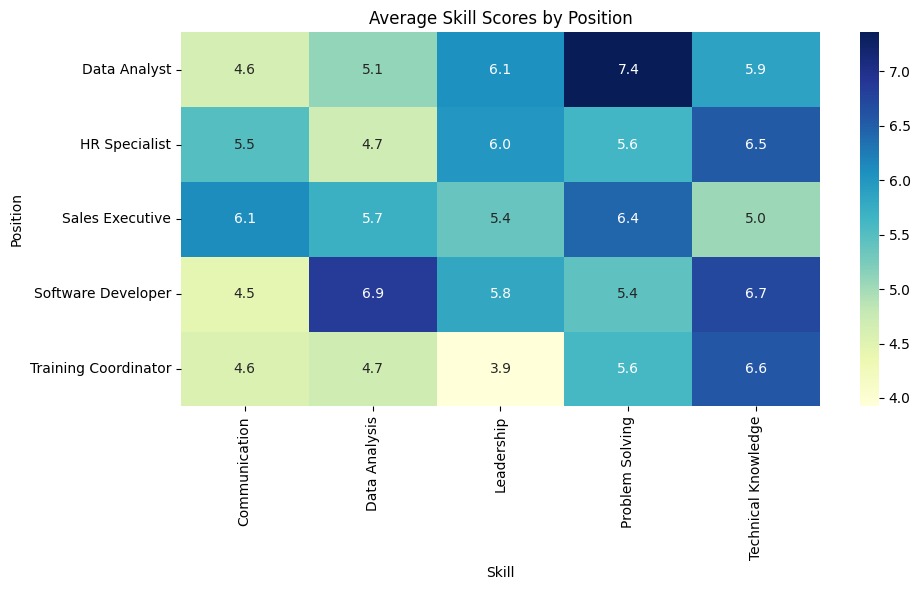

In [16]:
plt.figure(figsize=(10, 6))
sns.heatmap(avg_skill_by_position, annot=True, cmap="YlGnBu", fmt=".1f")
plt.title("Average Skill Scores by Position")
plt.xlabel("Skill")
plt.ylabel("Position")
plt.tight_layout()
plt.show()

In [17]:
skill_threshold = 6
low_tech_knowledge = avg_skill_by_position[avg_skill_by_position['Technical Knowledge'] < skill_threshold]

print("Positions with low Technical Knowledge:")
display(low_tech_knowledge[['Technical Knowledge']])

Positions with low Technical Knowledge:


skill_name,Technical Knowledge
position,
Data Analyst,5.869565
Sales Executive,5.047619


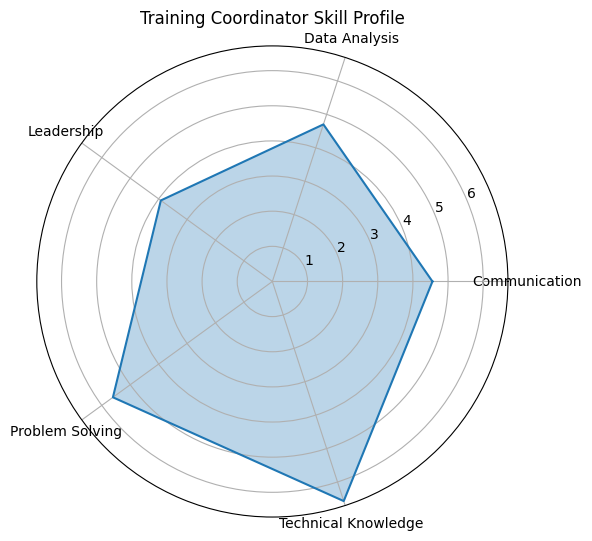

In [18]:
from math import pi

pos = 'Training Coordinator'
values = avg_skill_by_position.loc[pos].values
labels = avg_skill_by_position.columns.tolist()

angles = [n / float(len(labels)) * 2 * pi for n in range(len(labels))]
values = list(values) + [values[0]]
angles += [angles[0]]

plt.figure(figsize=(6, 6))
ax = plt.subplot(111, polar=True)
plt.xticks(angles[:-1], labels)
ax.plot(angles, values)
ax.fill(angles, values, alpha=0.3)
plt.title(f"{pos} Skill Profile")
plt.tight_layout()
plt.show()

# 4. Predictive Modeling (Regression)

Score prediction has been conducted based on completed trainings. Using the XGBoost regressor model, predictions were made with features such as age, position, training type, mentorship status, average satisfaction, and competency levels. Model performance was evaluated using RMSE.

In [19]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import shap

In [20]:
logs = training_logs[training_logs['completion_status'] == 'Completed'].copy()

logs = logs.merge(
    employees[['employee_id', 'age', 'position', 'education_level']],
    on='employee_id', how='left'
)

logs = logs.merge(
    trainings[['training_id', 'duration_hours', 'training_type', 'roi_target_usd']],
    on='training_id', how='left'
)

logs['mentorship_flag'] = logs['employee_id'].isin(mentorship['employee_id']).astype(int)

avg_skill = (
    skill_scores.groupby('employee_id')['score']
    .mean().reset_index()
    .rename(columns={'score': 'avg_skill_score'})
)
logs = logs.merge(avg_skill, on='employee_id', how='left')

avg_satisfaction = (
    survey_results.groupby('employee_id')['satisfaction_score']
    .mean().reset_index()
    .rename(columns={'satisfaction_score': 'avg_satisfaction'})
)
logs = logs.merge(avg_satisfaction, on='employee_id', how='left')

logs_encoded = pd.get_dummies(
    logs,
    columns=['position', 'education_level', 'training_type'],
    drop_first=True
)

final_features_df = logs_encoded.drop(
    columns=[
        'log_id', 'employee_id', 'training_id',
        'completion_status', 'completion_date'
    ]
)

print(final_features_df.head())

   score    weekday  age  duration_hours  roi_target_usd  mentorship_flag  \
0     61     Monday   28               4            1500                1   
1     71  Wednesday   35               2             300                0   
2     84     Friday   45               8             700                0   
3     96    Tuesday   32              13             300                1   
4     64     Sunday   35               1             500                0   

   avg_skill_score  avg_satisfaction  position_HR Specialist  \
0         4.500000          1.000000                   False   
1         7.666667          3.500000                    True   
2         5.800000          3.666667                   False   
3         4.250000          4.500000                   False   
4         6.500000          4.000000                   False   

   position_Sales Executive  position_Software Developer  \
0                     False                        False   
1                     False     

# 5. Model Explainability (SHAP)

The contributing factors of the prediction model have been explained using the SHAP method. This approach not only shows what the model predicts, but also visualizes why it makes those predictions.

RMSE: 18.25101073371684


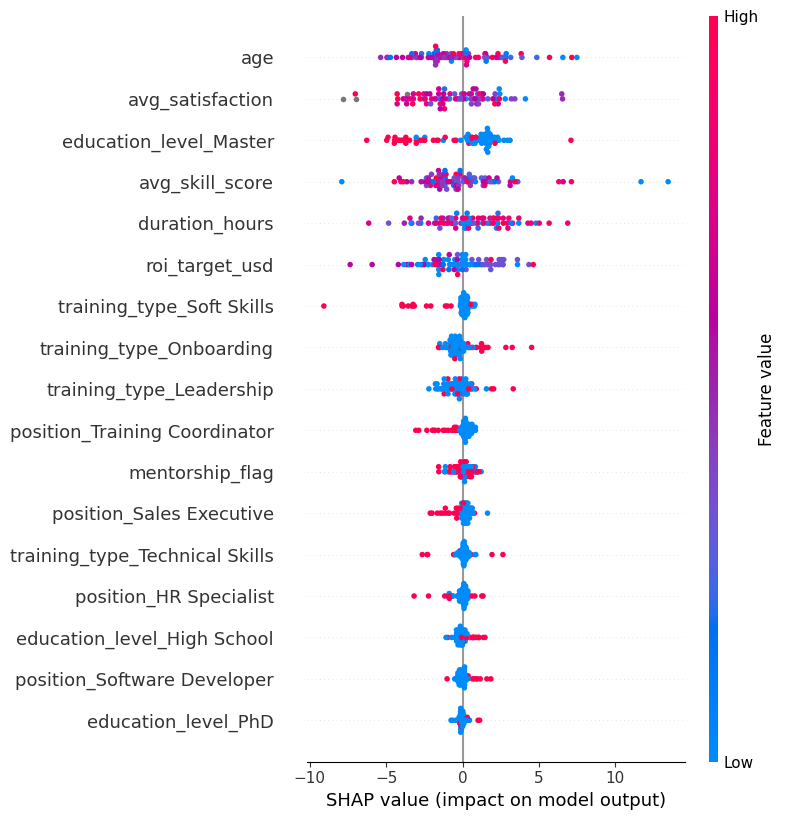

In [21]:
X = final_features_df.drop('score', axis=1)
X = X.select_dtypes(include=['int64', 'float64', 'bool'])
y = final_features_df['score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = XGBRegressor()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print("RMSE:", rmse)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test)